In [443]:
import random
from enum import Enum
from typing import Callable
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp


In [444]:
# GLOBALS
OPS = 10  # Number of operations per input
ITERS = 10000 # Number of iterations to run
NUM_MUTATIONS = 5  # Number of mutations to add when new coverage is found
SUDDEN_DRIFT_WINDOW = 100  # Window size for sudden drift detection
GRADUAL_DRIFT_WINDOW = 1000  # Window size for gradual drift detection
DRIFT_THRESHOLD = 0.05  # P-value threshold for drift detection
RANDOM_SEED = 42  # Random seed for reproducibility


In [445]:
class Operation(Enum):
    ADD = 0
    SUB = 1
    DIV = 2
    MUL = 3

class Calculator:
    """Simple integer-only calculator starting at 0.

    Operations:
      - add1(): add 1
      - sub1(): subtract 1
      - mul2(): multiply by 2
      - div2(): divide by 2 (rounds down for odd values)
      - reset(): reset value to 0 and clear log

    The calculator maintains a log of all values (starting with 0).
    Access the log via the .log attribute.
    """

    def __init__(self) -> None:
        self._value: int = 0
        self.log: list[int] = [0]

    def add1(self) -> None:
        self._value += 1
        self.log.append(self._value)

    def sub1(self) -> None:
        self._value -= 1
        self.log.append(self._value)

    def mul2(self) -> None:
        self._value *= 2
        self.log.append(self._value)

    def div2(self) -> None:
        self._value //= 2
        self.log.append(self._value)

    def reset(self) -> None:
        self._value = 0
        self.log = [0]

    def get(self) -> int:
        return self._value

    def parse(self, operations: list[Operation]) -> Callable[[], None]:
        """Parse a list of operations and return a nested function to execute them."""
        def execute() -> None:
            for op in operations:
                if op == Operation.ADD:
                    self.add1()
                elif op == Operation.SUB:
                    self.sub1()
                elif op == Operation.DIV:
                    self.div2()
                elif op == Operation.MUL:
                    self.mul2()
        return execute

    def calculate(self, operations: list[Operation]) -> list[int]:
        """Execute operations, copy log, reset, and return the copied log."""
        execute = self.parse(operations)
        execute()
        log_copy = self.log.copy()
        self.reset()
        return log_copy

    def __int__(self) -> int:
        return self._value

    def __repr__(self) -> str:
        return f"Calculator({self._value})"


In [446]:
def generate_random_operations(n: int = OPS) -> list[Operation]:
    """Generate a random list of operations of length n."""
    return [random.choice(list(Operation)) for _ in range(n)]

In [447]:
# Run calculator 1000 times with random operations and collect unique values
random.seed(RANDOM_SEED)
unique_values = set()
calc = Calculator()
random_coverage = []

for _ in range(ITERS):
    ops = generate_random_operations()
    log = calc.calculate(ops)
    unique_values.update(log)
    random_coverage.append(len(unique_values))

print(f"Total unique values generated: {len(unique_values)}")
print(f"Coverage over time: {random_coverage[:20]}...")  # Show first 20 steps
print(f"Final coverage: {random_coverage[-1]}")


Total unique values generated: 142
Coverage over time: [5, 5, 5, 8, 8, 8, 13, 13, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16]...
Final coverage: 142


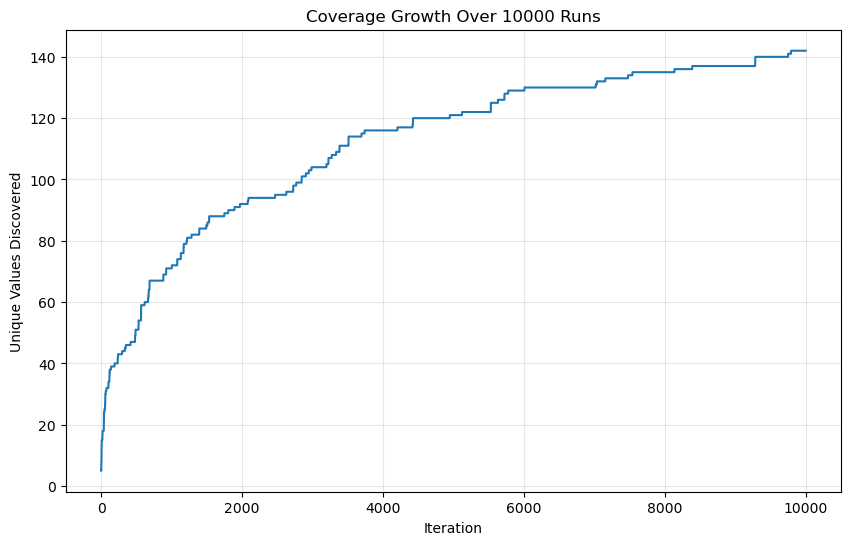

In [448]:
# Plot coverage over time
plt.figure(figsize=(10, 6))
plt.plot(random_coverage)
plt.xlabel('Iteration')
plt.ylabel('Unique Values Discovered')
plt.title(f'Coverage Growth Over {ITERS} Runs')
plt.grid(True, alpha=0.3)
plt.show()


In [449]:
class CoverageGuidedFuzzer:
    """Coverage-guided fuzzer that prioritizes operation sequences discovering new values."""
    
    def __init__(self, num_mutations: int = NUM_MUTATIONS):
        self.num_mutations = num_mutations
        self.unique_values: set[int] = set()
        self.coverage: list[int] = []
        self.corpus: list[list[Operation]] = []
        self.calc = Calculator()
    
    def fuzz(self, iters: int) -> tuple[set[int], list[int]]:
        """
        Run the fuzzer for the specified number of iterations.
        Uses queue-based selection like AFL++.
        
        Returns:
            tuple of (unique_values, coverage_over_time)
        """
        for i in range(iters):
            # Queue-based selection: pick next item from queue, or generate random if empty
            if self.corpus:
                # Pick the next item from the queue (round-robin)
                ops = self.corpus.pop(0)
            else:
                # Generate completely random operations (initial seed)
                ops = generate_random_operations()
            
            # Execute and check for new coverage
            log = self.calc.calculate(ops)
            old_coverage = len(self.unique_values)
            self.unique_values.update(log)
            new_coverage = len(self.unique_values)
            
            # If this sequence found new values, add multiple mutations to corpus
            if new_coverage > old_coverage:
                for _ in range(self.num_mutations):
                    self.corpus.append(self.mutate_operations(ops))
            
            self.coverage.append(new_coverage)
        
        return self.unique_values, self.coverage
    
    def mutate_operations(self, ops: list[Operation]) -> list[Operation]:
        """Mutate an operation sequence by changing or swapping operations (constant length)."""
        ops = ops.copy()
        mutation_type = random.choice(['change', 'swap'])
        
        if mutation_type == 'change' and len(ops) > 0:
            # Change a random operation
            idx = random.randint(0, len(ops) - 1)
            ops[idx] = random.choice(list(Operation))
        
        elif mutation_type == 'swap' and len(ops) > 1:
            # Swap two random operations
            idx1 = random.randint(0, len(ops) - 1)
            idx2 = random.randint(0, len(ops) - 1)
            ops[idx1], ops[idx2] = ops[idx2], ops[idx1]
        
        return ops


In [450]:
# Run coverage-guided fuzzer
print("Running coverage-guided fuzzer...")
random.seed(RANDOM_SEED)
fuzzer = CoverageGuidedFuzzer()
cg_unique_values, cg_coverage = fuzzer.fuzz(ITERS)

print(f"\nCoverage-Guided Fuzzer Results:")
print(f"Total unique values: {len(cg_unique_values)}")
print(f"Final coverage: {cg_coverage[-1]}")
print(f"Corpus size: {len(fuzzer.corpus)}")


Running coverage-guided fuzzer...

Coverage-Guided Fuzzer Results:
Total unique values: 189
Final coverage: 189
Corpus size: 0


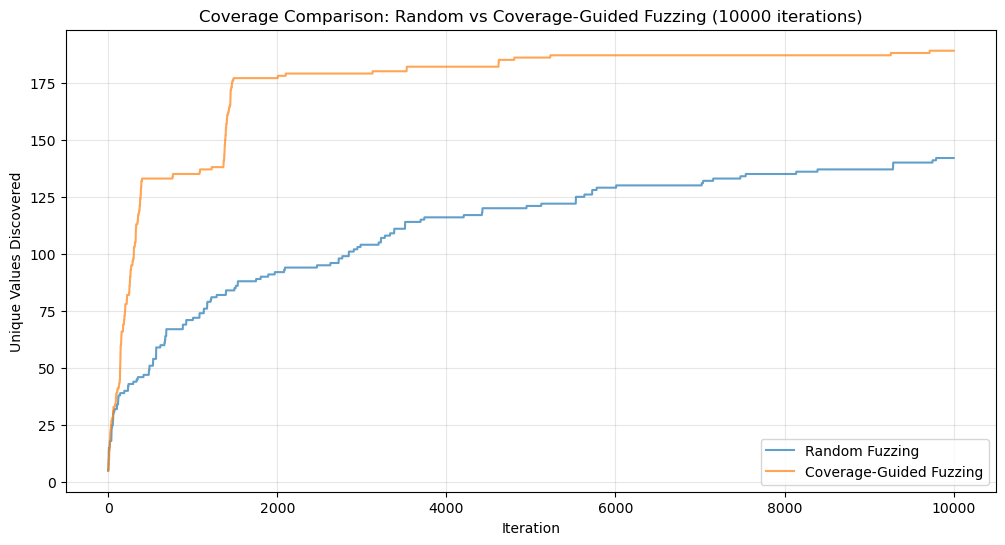


Final Coverage Comparison:
Random Fuzzing: 142 unique values
Coverage-Guided Fuzzing: 189 unique values
Improvement: 47 (33.10%)


In [451]:
# Compare coverage-guided vs random fuzzing
plt.figure(figsize=(12, 6))
plt.plot(random_coverage, label='Random Fuzzing', alpha=0.7)
plt.plot(cg_coverage, label='Coverage-Guided Fuzzing', alpha=0.7)
plt.xlabel('Iteration')
plt.ylabel('Unique Values Discovered')
plt.title(f'Coverage Comparison: Random vs Coverage-Guided Fuzzing ({ITERS} iterations)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\nFinal Coverage Comparison:")
print(f"Random Fuzzing: {random_coverage[-1]} unique values")
print(f"Coverage-Guided Fuzzing: {cg_coverage[-1]} unique values")
print(f"Improvement: {cg_coverage[-1] - random_coverage[-1]} ({((cg_coverage[-1] - random_coverage[-1]) / random_coverage[-1] * 100):.2f}%)")


In [452]:
class ConceptDriftFuzzer:
    """Coverage-guided fuzzer with KS drift detection."""
    
    def __init__(self, num_mutations: int = NUM_MUTATIONS, 
                 sudden_drift_window: int = SUDDEN_DRIFT_WINDOW,
                 gradual_drift_window: int = GRADUAL_DRIFT_WINDOW,
                 drift_threshold: float = DRIFT_THRESHOLD,
                 reset_on_drift: bool = False):
        self.num_mutations = num_mutations
        self.sudden_drift_window = sudden_drift_window
        self.gradual_drift_window = gradual_drift_window
        self.drift_threshold = drift_threshold
        self.reset_on_drift = reset_on_drift
        
        self.unique_values: set[int] = set()
        self.coverage: list[int] = []
        self.corpus: list[list[Operation]] = []
        self.calc = Calculator()
        
        # Drift detection tracking
        self.values_window: list[list[int]] = []  # Store logs for each iteration
        self.sudden_drift_detected_at: list[int] = []  # Iterations where sudden drift was detected
        self.gradual_drift_detected_at: list[int] = []  # Iterations where gradual drift was detected
        self.ks_statistics: list[float] = []  # KS statistic at each check
        self.corpus_reset_at: list[int] = []  # Iterations where corpus was reset
    
    def fuzz(self, iters: int) -> tuple[set[int], list[int]]:
        """
        Run the fuzzer for the specified number of iterations.
        Monitors for concept drift using KS test.
        
        Returns:
            tuple of (unique_values, coverage_over_time)
        """
        for i in range(iters):
            # Queue-based selection: pick next item from queue, or generate random if empty
            if self.corpus:
                ops = self.corpus.pop(0)
            else:
                ops = generate_random_operations()
            
            # Execute and check for new coverage
            log = self.calc.calculate(ops)
            old_coverage = len(self.unique_values)
            self.unique_values.update(log)
            new_coverage = len(self.unique_values)
            
            # Store values for drift detection
            self.values_window.append(log)
            
            # Check for sudden drift every sudden_drift_window iterations
            if i > 0 and i % self.sudden_drift_window == 0 and len(self.values_window) >= 2 * self.sudden_drift_window:
                self._check_drift(i, drift_type='sudden')
            
            # Check for gradual drift every gradual_drift_window iterations
            if i > 0 and i % self.gradual_drift_window == 0 and len(self.values_window) >= 2 * self.gradual_drift_window:
                self._check_drift(i, drift_type='gradual')
            
            # If this sequence found new values, add multiple mutations to corpus
            if new_coverage > old_coverage:
                for _ in range(self.num_mutations):
                    self.corpus.append(self.mutate_operations(ops))
            
            self.coverage.append(new_coverage)
        
        return self.unique_values, self.coverage
    
    def _check_drift(self, iteration: int, drift_type: str):
        """Check for concept drift using KS test."""
        # Select window size based on drift type
        window_size = self.sudden_drift_window if drift_type == 'sudden' else self.gradual_drift_window
        
        # Get the previous window and current window
        prev_window_start = max(0, len(self.values_window) - 2 * window_size)
        prev_window_end = len(self.values_window) - window_size
        curr_window_start = len(self.values_window) - window_size
        
        # Flatten the logs into distributions
        prev_values = [val for log in self.values_window[prev_window_start:prev_window_end] for val in log]
        curr_values = [val for log in self.values_window[curr_window_start:] for val in log]
        
        if len(prev_values) > 0 and len(curr_values) > 0:
            # Perform KS test
            ks_stat, p_value = ks_2samp(prev_values, curr_values)
            self.ks_statistics.append(ks_stat)
            
            # Detect drift if p-value is below threshold
            if p_value < self.drift_threshold:
                if drift_type == 'sudden':
                    self.sudden_drift_detected_at.append(iteration)
                    print(f"[Sudden Drift Detected] Iteration {iteration}: KS statistic = {ks_stat:.4f}, p-value = {p_value:.4f}")
                    
                    # Reset corpus only on sudden drift if enabled
                    if self.reset_on_drift:
                        corpus_size = len(self.corpus)
                        self.corpus = []
                        self.corpus_reset_at.append(iteration)
                        print(f"  -> Corpus reset (cleared {corpus_size} entries)")
                else:
                    self.gradual_drift_detected_at.append(iteration)
                    print(f"[Gradual Drift Detected] Iteration {iteration}: KS statistic = {ks_stat:.4f}, p-value = {p_value:.4f}")
    
    def mutate_operations(self, ops: list[Operation]) -> list[Operation]:
        """Mutate an operation sequence by changing or swapping operations (constant length)."""
        ops = ops.copy()
        mutation_type = random.choice(['change', 'swap'])
        
        if mutation_type == 'change' and len(ops) > 0:
            idx = random.randint(0, len(ops) - 1)
            ops[idx] = random.choice(list(Operation))
        
        elif mutation_type == 'swap' and len(ops) > 1:
            idx1 = random.randint(0, len(ops) - 1)
            idx2 = random.randint(0, len(ops) - 1)
            ops[idx1], ops[idx2] = ops[idx2], ops[idx1]
        
        return ops


In [453]:
# Run concept drift fuzzer
print("Running concept drift fuzzer...")
random.seed(RANDOM_SEED)
drift_fuzzer = ConceptDriftFuzzer()
cd_unique_values, cd_coverage = drift_fuzzer.fuzz(ITERS)

print(f"\nConcept Drift Fuzzer Results:")
print(f"Total unique values: {len(cd_unique_values)}")
print(f"Final coverage: {cd_coverage[-1]}")
print(f"Corpus size: {len(drift_fuzzer.corpus)}")
print(f"Sudden drifts detected: {len(drift_fuzzer.sudden_drift_detected_at)}")
print(f"Gradual drifts detected: {len(drift_fuzzer.gradual_drift_detected_at)}")
print(f"Sudden drift iterations: {drift_fuzzer.sudden_drift_detected_at[:10]}..." if len(drift_fuzzer.sudden_drift_detected_at) > 10 else f"Sudden drift iterations: {drift_fuzzer.sudden_drift_detected_at}")
print(f"Gradual drift iterations: {drift_fuzzer.gradual_drift_detected_at[:10]}..." if len(drift_fuzzer.gradual_drift_detected_at) > 10 else f"Gradual drift iterations: {drift_fuzzer.gradual_drift_detected_at}")


Running concept drift fuzzer...
[Sudden Drift Detected] Iteration 200: KS statistic = 0.6436, p-value = 0.0000
[Sudden Drift Detected] Iteration 300: KS statistic = 0.1573, p-value = 0.0000
[Sudden Drift Detected] Iteration 400: KS statistic = 0.2327, p-value = 0.0000
[Sudden Drift Detected] Iteration 500: KS statistic = 0.3891, p-value = 0.0000
[Sudden Drift Detected] Iteration 1200: KS statistic = 0.0664, p-value = 0.0157
[Sudden Drift Detected] Iteration 1300: KS statistic = 0.1109, p-value = 0.0000
[Sudden Drift Detected] Iteration 1400: KS statistic = 0.1682, p-value = 0.0000
[Sudden Drift Detected] Iteration 1500: KS statistic = 0.3200, p-value = 0.0000
[Sudden Drift Detected] Iteration 1600: KS statistic = 0.5591, p-value = 0.0000
[Sudden Drift Detected] Iteration 2000: KS statistic = 0.0591, p-value = 0.0429
[Gradual Drift Detected] Iteration 2000: KS statistic = 0.1631, p-value = 0.0000
[Sudden Drift Detected] Iteration 2400: KS statistic = 0.0791, p-value = 0.0020
[Sudden Dri

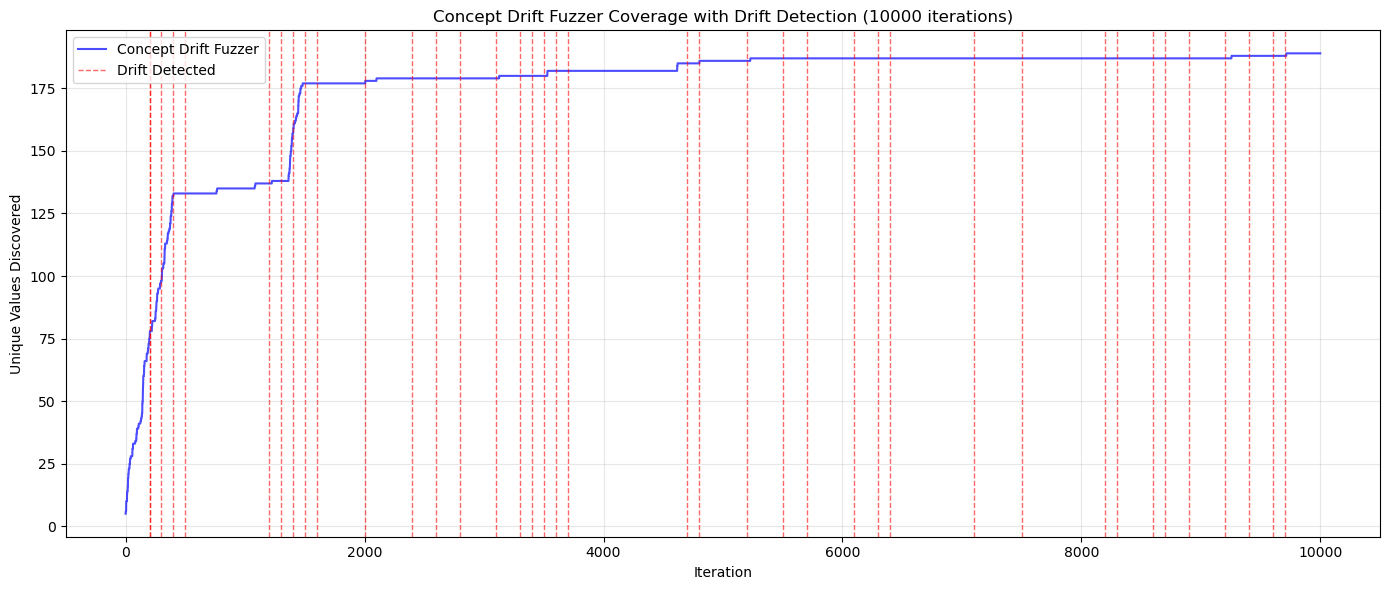


Total drifts detected: 38


In [454]:
# Plot concept drift fuzzer coverage with drift markers
plt.figure(figsize=(14, 6))
plt.plot(cd_coverage, label='Concept Drift Fuzzer', color='blue', alpha=0.7)

# Mark drift detection points with red dotted vertical lines
for drift_iter in drift_fuzzer.sudden_drift_detected_at:
    plt.axvline(x=drift_iter, color='red', linestyle='--', alpha=0.6, linewidth=1)

# Add a legend entry for drift markers
if len(drift_fuzzer.sudden_drift_detected_at) > 0:
    plt.axvline(x=drift_fuzzer.sudden_drift_detected_at[0], color='red', linestyle='--', 
                alpha=0.6, linewidth=1, label='Drift Detected')

plt.xlabel('Iteration')
plt.ylabel('Unique Values Discovered')
plt.title(f'Concept Drift Fuzzer Coverage with Drift Detection ({ITERS} iterations)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTotal drifts detected: {len(drift_fuzzer.sudden_drift_detected_at)}")


In [455]:
# Run concept drift fuzzer with corpus reset on drift
print("Running concept drift fuzzer with reset_on_drift=True...")
random.seed(RANDOM_SEED)
drift_fuzzer_reset = ConceptDriftFuzzer(reset_on_drift=True)
cd_reset_unique_values, cd_reset_coverage = drift_fuzzer_reset.fuzz(ITERS)

print(f"\nConcept Drift Fuzzer (with reset) Results:")
print(f"Total unique values: {len(cd_reset_unique_values)}")
print(f"Final coverage: {cd_reset_coverage[-1]}")
print(f"Corpus size: {len(drift_fuzzer_reset.corpus)}")
print(f"Drifts detected: {len(drift_fuzzer_reset.sudden_drift_detected_at)}")
print(f"Drift iterations: {drift_fuzzer_reset.sudden_drift_detected_at[:10]}..." if len(drift_fuzzer_reset.sudden_drift_detected_at) > 10 else f"Drift iterations: {drift_fuzzer_reset.sudden_drift_detected_at}")

Running concept drift fuzzer with reset_on_drift=True...
[Sudden Drift Detected] Iteration 200: KS statistic = 0.6436, p-value = 0.0000
  -> Corpus reset (cleared 34 entries)
[Sudden Drift Detected] Iteration 300: KS statistic = 0.1182, p-value = 0.0000
  -> Corpus reset (cleared 14 entries)
[Sudden Drift Detected] Iteration 400: KS statistic = 0.4136, p-value = 0.0000
  -> Corpus reset (cleared 23 entries)
[Sudden Drift Detected] Iteration 500: KS statistic = 0.0791, p-value = 0.0020
  -> Corpus reset (cleared 12 entries)
[Sudden Drift Detected] Iteration 600: KS statistic = 0.1055, p-value = 0.0000
  -> Corpus reset (cleared 0 entries)
[Sudden Drift Detected] Iteration 700: KS statistic = 0.2209, p-value = 0.0000
  -> Corpus reset (cleared 0 entries)
[Sudden Drift Detected] Iteration 900: KS statistic = 0.0736, p-value = 0.0051
  -> Corpus reset (cleared 0 entries)
[Sudden Drift Detected] Iteration 1300: KS statistic = 0.0891, p-value = 0.0003
  -> Corpus reset (cleared 0 entries)
[S

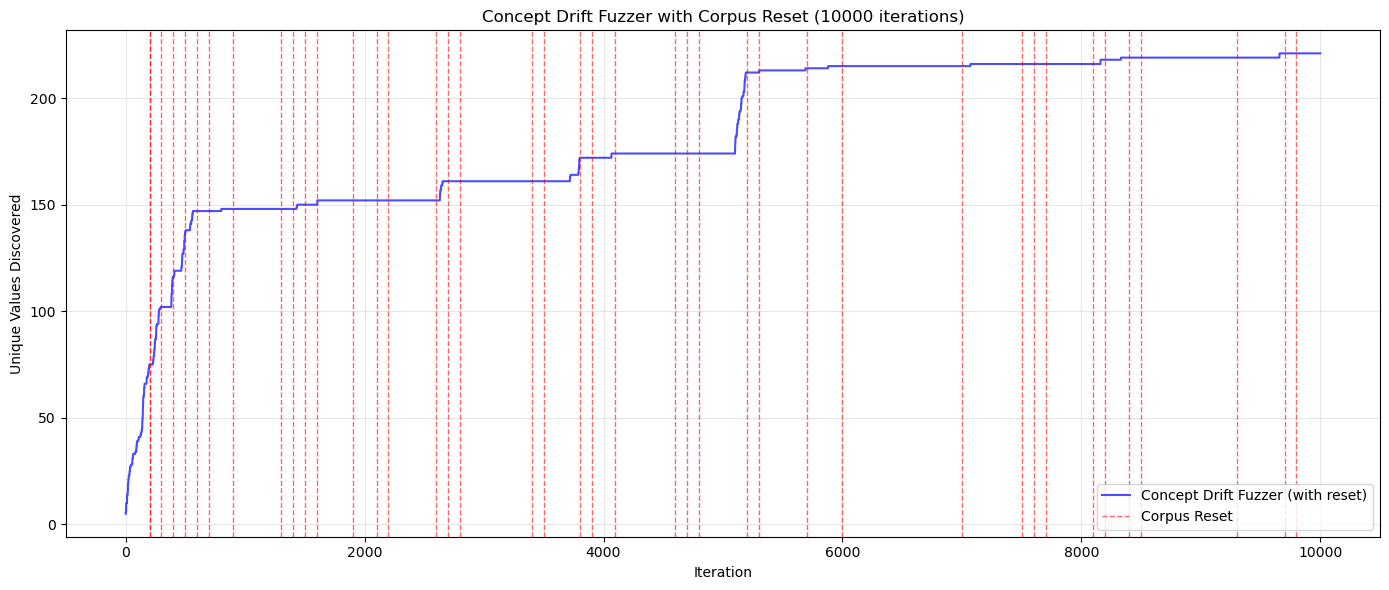


Total corpus resets: 40
Reset iterations: [200, 300, 400, 500, 600, 700, 900, 1300, 1400, 1500, 1600, 1900, 2100, 2200, 2600, 2700, 2800, 3400, 3500, 3800, 3900, 4100, 4600, 4700, 4800, 5200, 5300, 5700, 6000, 7000, 7500, 7600, 7700, 8100, 8200, 8400, 8500, 9300, 9700, 9800]


In [456]:
# Plot concept drift fuzzer with reset enabled and mark reset points
plt.figure(figsize=(14, 6))
plt.plot(cd_reset_coverage, label='Concept Drift Fuzzer (with reset)', color='blue', alpha=0.7)

# Mark corpus reset points with red dotted vertical lines
for reset_iter in drift_fuzzer_reset.corpus_reset_at:
    plt.axvline(x=reset_iter, color='red', linestyle='--', alpha=0.6, linewidth=1)

# Add a legend entry for reset markers
if len(drift_fuzzer_reset.corpus_reset_at) > 0:
    plt.axvline(x=drift_fuzzer_reset.corpus_reset_at[0], color='red', linestyle='--', 
                alpha=0.6, linewidth=1, label='Corpus Reset')

plt.xlabel('Iteration')
plt.ylabel('Unique Values Discovered')
plt.title(f'Concept Drift Fuzzer with Corpus Reset ({ITERS} iterations)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTotal corpus resets: {len(drift_fuzzer_reset.corpus_reset_at)}")
print(f"Reset iterations: {drift_fuzzer_reset.corpus_reset_at}")

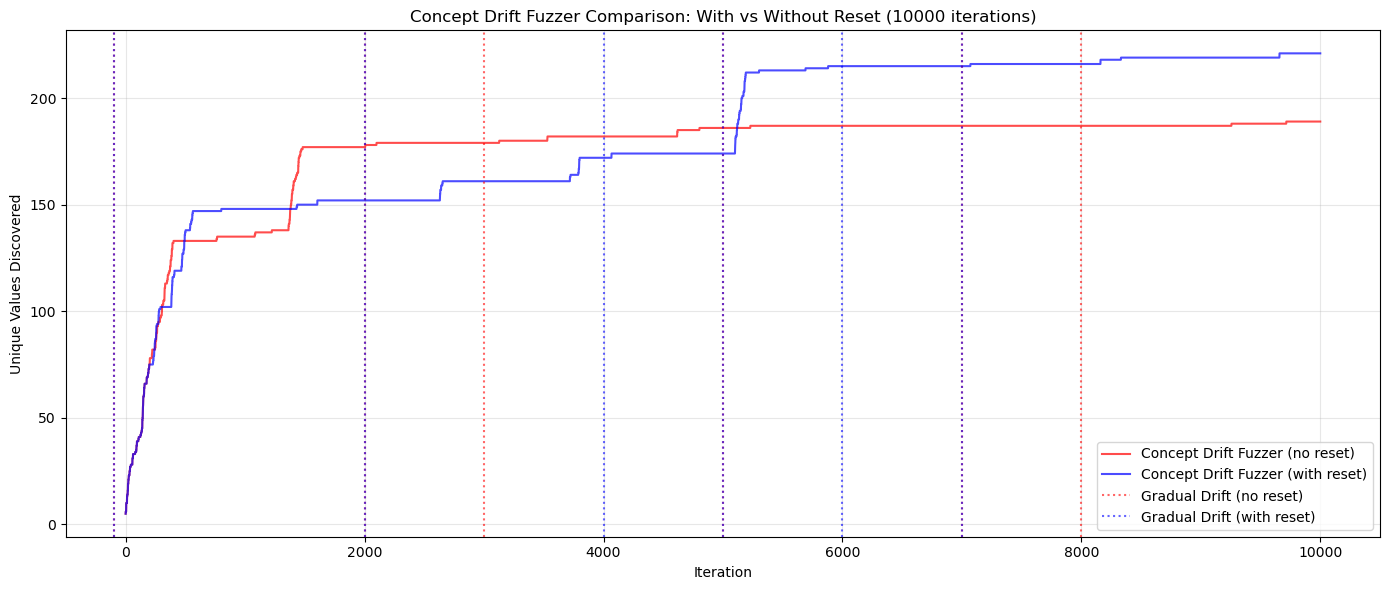


Comparison Summary:
No Reset - Final coverage: 189, Sudden drifts: 38, Gradual drifts: 5
With Reset - Final coverage: 221, Resets performed: 40, Gradual drifts: 5
Difference: 32 unique values (16.93%)


In [458]:
# Compare concept drift fuzzers with and without reset
plt.figure(figsize=(14, 6))
plt.plot(cd_coverage, label='Concept Drift Fuzzer (no reset)', color='red', alpha=0.7)
plt.plot(cd_reset_coverage, label='Concept Drift Fuzzer (with reset)', color='blue', alpha=0.7)

# Mark gradual drift points for no-reset fuzzer with red dotted lines
for drift_iter in drift_fuzzer.gradual_drift_detected_at:
    plt.axvline(x=drift_iter, color='red', linestyle=':', alpha=0.6, linewidth=1.5)

# Mark gradual drift points for with-reset fuzzer with blue dotted lines
for drift_iter in drift_fuzzer_reset.gradual_drift_detected_at:
    plt.axvline(x=drift_iter, color='blue', linestyle=':', alpha=0.6, linewidth=1.5)

# Add legend entries for gradual drift markers
if len(drift_fuzzer.gradual_drift_detected_at) > 0:
    plt.axvline(x=-100, color='red', linestyle=':', alpha=0.6, linewidth=1.5, label='Gradual Drift (no reset)')
if len(drift_fuzzer_reset.gradual_drift_detected_at) > 0:
    plt.axvline(x=-100, color='blue', linestyle=':', alpha=0.6, linewidth=1.5, label='Gradual Drift (with reset)')

plt.xlabel('Iteration')
plt.ylabel('Unique Values Discovered')
plt.title(f'Concept Drift Fuzzer Comparison: With vs Without Reset ({ITERS} iterations)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nComparison Summary:")
print(f"No Reset - Final coverage: {cd_coverage[-1]}, Sudden drifts: {len(drift_fuzzer.sudden_drift_detected_at)}, Gradual drifts: {len(drift_fuzzer.gradual_drift_detected_at)}")
print(f"With Reset - Final coverage: {cd_reset_coverage[-1]}, Resets performed: {len(drift_fuzzer_reset.corpus_reset_at)}, Gradual drifts: {len(drift_fuzzer_reset.gradual_drift_detected_at)}")
print(f"Difference: {cd_reset_coverage[-1] - cd_coverage[-1]} unique values ({((cd_reset_coverage[-1] - cd_coverage[-1]) / cd_coverage[-1] * 100):.2f}%)")